# Predicting Images and Plotting the Accuracies as a Heatmap

## Imports and global variables

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
from PIL import Image
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
label_map = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

## Load the Previously saved models

In [2]:
def load_trained_model(model_path: str, state_dict_path: str):
    """
    Load the entire model object and set it to evaluation mode.

    :References:
    - Load Entire Model: https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model

    """
    if not os.path.exists(model_path):
        raise ValueError(f"Path '{model_path}' does not exist")
    if not os.path.exists(state_dict_path):
        raise ValueError(f"Path '{state_dict_path}' does not exist")

    # Load the entire model (architecture + weights)
    loaded_model = torch.load(model_path, weights_only=False)
    loaded_state_dict = torch.load(state_dict_path, weights_only=False)

    # Check if the loaded model is of the correct type
    if not isinstance(loaded_model, models.ConvNeXt):
        raise ValueError("Loaded model does not match the current model class")

    # Load State Dict and set the model to evaluation mode
    loaded_model.load_state_dict(loaded_state_dict)
    loaded_model.to(device)
    return loaded_model

pretrained_model = load_trained_model(
    model_path=r"./final_models\PretrainedIsTheCrown.pth",
    state_dict_path=r"./final_models/PretrainedIsTheCrown_state_dict.pth"
)
scratch_model = load_trained_model(
    model_path=r"./final_models/TheScratchMachine.pth",
    state_dict_path=r"./final_models/TheScratchMachine_state_dict.pth"
)

## Load the Dataset for the prediction

In [3]:
print("\x1b[32m\nInitializing Datasets and Dataloaders...\x1b[38;5;188m\n")

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.3444, 0.3803, 0.4078], [0.0931, 0.0648, 0.0542])
])

eurosat_validation_dataset = datasets.ImageFolder(r'./eurosat/2750', transform=preprocess)
eurosat_validation_data = DataLoader(eurosat_validation_dataset, batch_size=32, shuffle=False, num_workers=4)


Initializing Datasets and Dataloaders...



## Test Models with single Prediction

In [4]:
def predict_image(model, image_path):
    """
    Predict the label of the test image using the trained model
    """
    model.eval()

    file_path = os.path.dirname(image_path)
    label = file_path.split('/')[-1]

    # Load and preprocess the image
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Move image to the appropriate device (GPU or CPU)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)

    print(f'\nActual Class: {label}\nPredicted Class: {label_map[predicted.item()]}\nCorrect Prediction: {label_map[predicted.item()] == label}\n')


image_file = "./eurosat/2750/Industrial/Industrial_277.jpg"
predict_image(pretrained_model, image_file)
predict_image(scratch_model, image_file)


Actual Class: Industrial
Predicted Class: Industrial
Correct Prediction: True


Actual Class: Industrial
Predicted Class: Industrial
Correct Prediction: True



## Predict whole Dataset
(no Accuracies/Percentages of correct Predictions are calculated, because smth buggy ¯\(°_o)/¯ and they are not needed)

In [6]:
def predict_dataset(model, testloader):
    """
    Predicts the labels of the test images using the trained model

    :reference:
        - Code Origin: https://stackoverflow.com/a/67207533
        - Creator: https://stackoverflow.com/users/9281849/bolero

    :param model: The trained PyTorch model
    :param testloader: A PyTorch DataLoader
    :return: A list of predicted labels (one for each test image)
    """
    confusion_matrix = np.zeros((10, 10), dtype=int)

    print("\x1b[32m\nPredicting images...\n\x1b[38;5;188m\n")
    with torch.no_grad():
        for data in testloader:
            images, labels = data

            # Ensure batch dimension is added (if needed)
            images = images.unsqueeze(0) if images.dim() == 3 else images
            images = images.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)

            confusion_matrix[labels][predicted] += 1

    return confusion_matrix

# uncomment to decide which model
# data = predict_dataset(pretrained_model, eurosat_validation_dataset)
# print("Pretrained:\n",data)

# data = predict_dataset(scratch_model, eurosat_validation_dataset)
# print("Scratch:\n",data)

print("""Pretrained:
[[2950   1    2    0    0   11   24    0    9    3]
[   1 2981   12    0    0    5    0    0    0    1]
[   0    7 2947    3    0   13   25    2    0    3]
[   4    2    4 2425    9    3   12    4   36    1]
[   0    0    0    2 2481    0    1   16    0    0]
[  16   11   23    0    0 1941    3    0    3    3]
[  20    0   67    5    3    3 2397    3    2    0]
[   0    0    0    2    6    0    1 2991    0    0]
[   4    1    5   26    6    5    0    0 2449    4]
[   1    6    2    1    0    2    0    0    2 2986]]

Scratch:
[[2814   12   34    0    0   18   96    1   13   12]
[   0 2969   19    0    0   10    0    0    0    2]
[   7    7 2871    1    2    8   92    4    0    8]
[   5    1   17 2350   22    6   41   25   33    0]
[   0    0    7    8 2442    1    7   33    2    0]
[  21   42   27    1    0 1874   24    0    5    6]
[  19    2   46    0    5    6 2415    0    7    0]
[   0    2    4    0    4    0    1 2988    1    0]
[  20    2   27   14    2   37   18    0 2378    2]
[   8   78    0    0    0    3    0    0    3 2908]]
""")

Pretrained:
[[2950   1    2    0    0   11   24    0    9    3]
[   1 2981   12    0    0    5    0    0    0    1]
[   0    7 2947    3    0   13   25    2    0    3]
[   4    2    4 2425    9    3   12    4   36    1]
[   0    0    0    2 2481    0    1   16    0    0]
[  16   11   23    0    0 1941    3    0    3    3]
[  20    0   67    5    3    3 2397    3    2    0]
[   0    0    0    2    6    0    1 2991    0    0]
[   4    1    5   26    6    5    0    0 2449    4]
[   1    6    2    1    0    2    0    0    2 2986]]

Scratch:
[[2814   12   34    0    0   18   96    1   13   12]
[   0 2969   19    0    0   10    0    0    0    2]
[   7    7 2871    1    2    8   92    4    0    8]
[   5    1   17 2350   22    6   41   25   33    0]
[   0    0    7    8 2442    1    7   33    2    0]
[  21   42   27    1    0 1874   24    0    5    6]
[  19    2   46    0    5    6 2415    0    7    0]
[   0    2    4    0    4    0    1 2988    1    0]
[  20    2   27   14    2   37   18    0

Note: not all Classes have 3000 images, some have only 2500 or 2000

In [17]:
pretrained_data = [
    [2950,   1,    2,    0,    0,   11,   24,    0,    9,    3],
    [1, 2981,   12,    0,    0,    5,    0,    0,    0,    1],
    [0,    7, 2947,    3,    0,   13,   25,    2,    0,    3],
    [4,    2,    4, 2425,    9,    3,   12,    4,   36,    1],
    [0,    0,    0,    2, 2481,    0,    1,   16,    0,    0],
    [16,   11,   23,    0,    0, 1941,    3,    0,    3,    3],
    [20,    0,   67,    5,    3,    3, 2397,    3,    2,    0],
    [0,    0,    0,    2,    6,    0,    1, 2991,    0,    0],
    [4,    1,    5,   26,    6,    5,    0,    0, 2449,    4],
    [1,    6,    2,    1,    0,    2,    0,    0,    2, 2986]
]
scratch_data = [
    [2814,   12,   34,    0,    0,   18,   96,    1,   13,   12],
    [   0, 2969,   19,    0,    0,   10,    0,    0,    0,    2],
    [   7,    7, 2871,    1,    2,    8,   92,    4,    0,    8],
    [   5,    1,   17, 2350,   22,    6,   41,   25,   33,    0],
    [   0,    0,    7,    8, 2442,    1,    7,   33,    2,    0],
    [  21,   42,   27,    1,    0, 1874,   24,    0,    5,    6],
    [  19,    2,   46,    0,    5,    6, 2415,    0,    7,    0],
    [   0,    2,    4,    0,    4,    0,    1, 2988,    1,    0],
    [  20,    2,   27,   14,    2,   37,   18,    0, 2378,    2],
    [   8,   78,    0,    0,    0,    3,    0,    0,    3, 2908]
]

## Calculate relative Accuracies

In [13]:
def calculate_relatives(data, version):
    images_per_label = [3000,3000,3000,2500,2500,2000,2500,3000,2500,3000]
    print(f"{version}_data_relative = [")
    for row in data:
        for i,_ in enumerate(images_per_label):
            row[i] = round(row[i]/images_per_label[i], 4)
    
        print(f"\t{row},")
    print("]")
    
    
calculate_relatives(pretrained_data, "pretrained")
calculate_relatives(scratch_data, "scratch")

pretrained_data_relative = [
	[0.9833, 0.0003, 0.0007, 0.0, 0.0, 0.0055, 0.0096, 0.0, 0.0036, 0.001],
	[0.0003, 0.9937, 0.004, 0.0, 0.0, 0.0025, 0.0, 0.0, 0.0, 0.0003],
	[0.0, 0.0023, 0.9823, 0.0012, 0.0, 0.0065, 0.01, 0.0007, 0.0, 0.001],
	[0.0013, 0.0007, 0.0013, 0.97, 0.0036, 0.0015, 0.0048, 0.0013, 0.0144, 0.0003],
	[0.0, 0.0, 0.0, 0.0008, 0.9924, 0.0, 0.0004, 0.0053, 0.0, 0.0],
	[0.0053, 0.0037, 0.0077, 0.0, 0.0, 0.9705, 0.0012, 0.0, 0.0012, 0.001],
	[0.0067, 0.0, 0.0223, 0.002, 0.0012, 0.0015, 0.9588, 0.001, 0.0008, 0.0],
	[0.0, 0.0, 0.0, 0.0008, 0.0024, 0.0, 0.0004, 0.997, 0.0, 0.0],
	[0.0013, 0.0003, 0.0017, 0.0104, 0.0024, 0.0025, 0.0, 0.0, 0.9796, 0.0013],
	[0.0003, 0.002, 0.0007, 0.0004, 0.0, 0.001, 0.0, 0.0, 0.0008, 0.9953],
]
scratch_data_relative = [
	[0.938, 0.004, 0.0113, 0.0, 0.0, 0.009, 0.0384, 0.0003, 0.0052, 0.004],
	[0.0, 0.9897, 0.0063, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0007],
	[0.0023, 0.0023, 0.957, 0.0004, 0.0008, 0.004, 0.0368, 0.0013, 0.0, 0.0027],
	[0.0017, 

In [18]:
pretrained_data_relative = [
	[0.9833, 0.0003, 0.0007, 0.0, 0.0, 0.0055, 0.0096, 0.0, 0.0036, 0.001],
	[0.0003, 0.9937, 0.004, 0.0, 0.0, 0.0025, 0.0, 0.0, 0.0, 0.0003],
	[0.0, 0.0023, 0.9823, 0.0012, 0.0, 0.0065, 0.01, 0.0007, 0.0, 0.001],
	[0.0013, 0.0007, 0.0013, 0.97, 0.0036, 0.0015, 0.0048, 0.0013, 0.0144, 0.0003],
	[0.0, 0.0, 0.0, 0.0008, 0.9924, 0.0, 0.0004, 0.0053, 0.0, 0.0],
	[0.0053, 0.0037, 0.0077, 0.0, 0.0, 0.9705, 0.0012, 0.0, 0.0012, 0.001],
	[0.0067, 0.0, 0.0223, 0.002, 0.0012, 0.0015, 0.9588, 0.001, 0.0008, 0.0],
	[0.0, 0.0, 0.0, 0.0008, 0.0024, 0.0, 0.0004, 0.997, 0.0, 0.0],
	[0.0013, 0.0003, 0.0017, 0.0104, 0.0024, 0.0025, 0.0, 0.0, 0.9796, 0.0013],
	[0.0003, 0.002, 0.0007, 0.0004, 0.0, 0.001, 0.0, 0.0, 0.0008, 0.9953],
]
scratch_data_relative = [
	[0.938, 0.004, 0.0113, 0.0, 0.0, 0.009, 0.0384, 0.0003, 0.0052, 0.004],
	[0.0, 0.9897, 0.0063, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0007],
	[0.0023, 0.0023, 0.957, 0.0004, 0.0008, 0.004, 0.0368, 0.0013, 0.0, 0.0027],
	[0.0017, 0.0003, 0.0057, 0.94, 0.0088, 0.003, 0.0164, 0.0083, 0.0132, 0.0],
	[0.0, 0.0, 0.0023, 0.0032, 0.9768, 0.0005, 0.0028, 0.011, 0.0008, 0.0],
	[0.007, 0.014, 0.009, 0.0004, 0.0, 0.937, 0.0096, 0.0, 0.002, 0.002],
	[0.0063, 0.0007, 0.0153, 0.0, 0.002, 0.003, 0.966, 0.0, 0.0028, 0.0],
	[0.0, 0.0007, 0.0013, 0.0, 0.0016, 0.0, 0.0004, 0.996, 0.0004, 0.0],
	[0.0067, 0.0007, 0.009, 0.0056, 0.0008, 0.0185, 0.0072, 0.0, 0.9512, 0.0007],
	[0.0027, 0.026, 0.0, 0.0, 0.0, 0.0015, 0.0, 0.0, 0.0012, 0.9693],
]

## Plot the Confusion Matrices


Plotting Matrix now




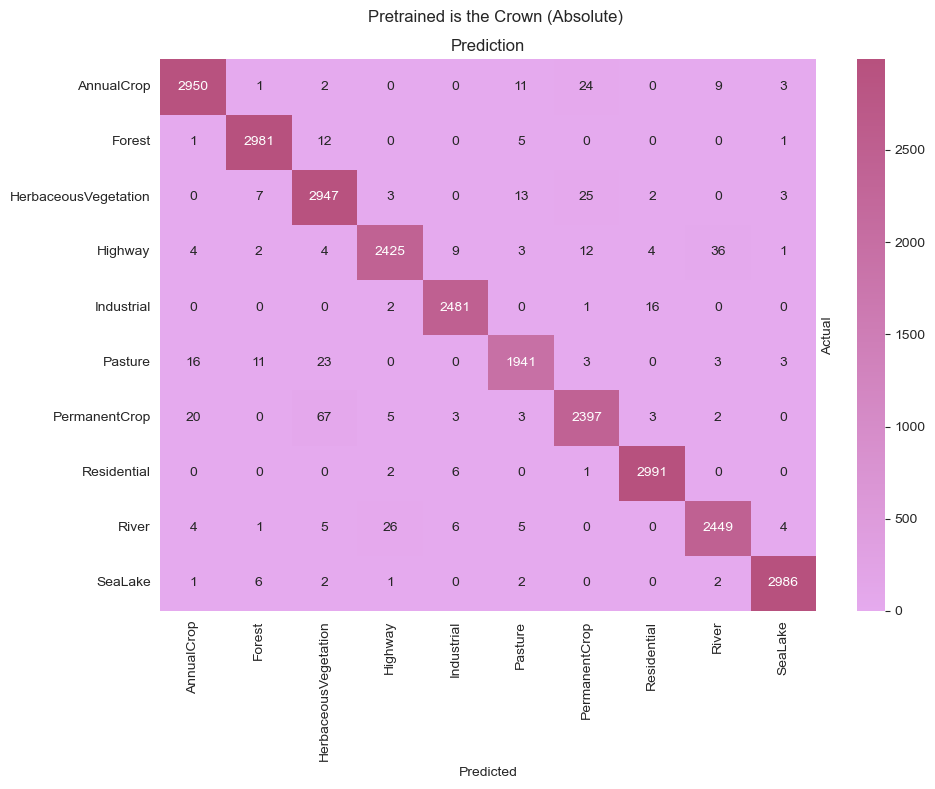


Plotting Matrix now




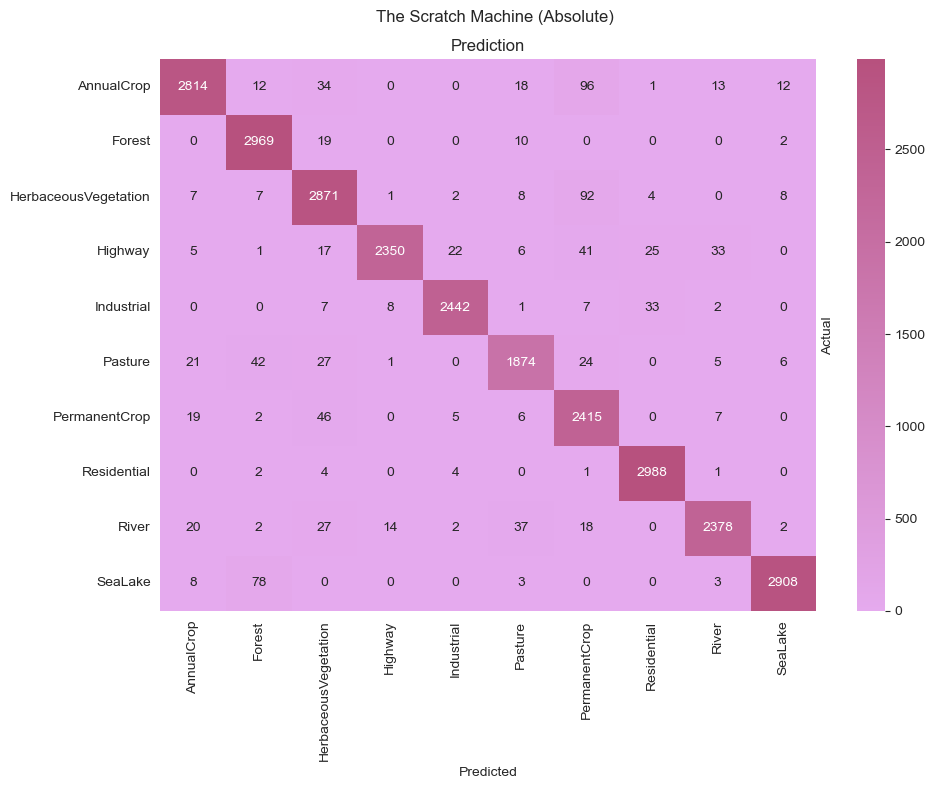


Plotting Matrix now




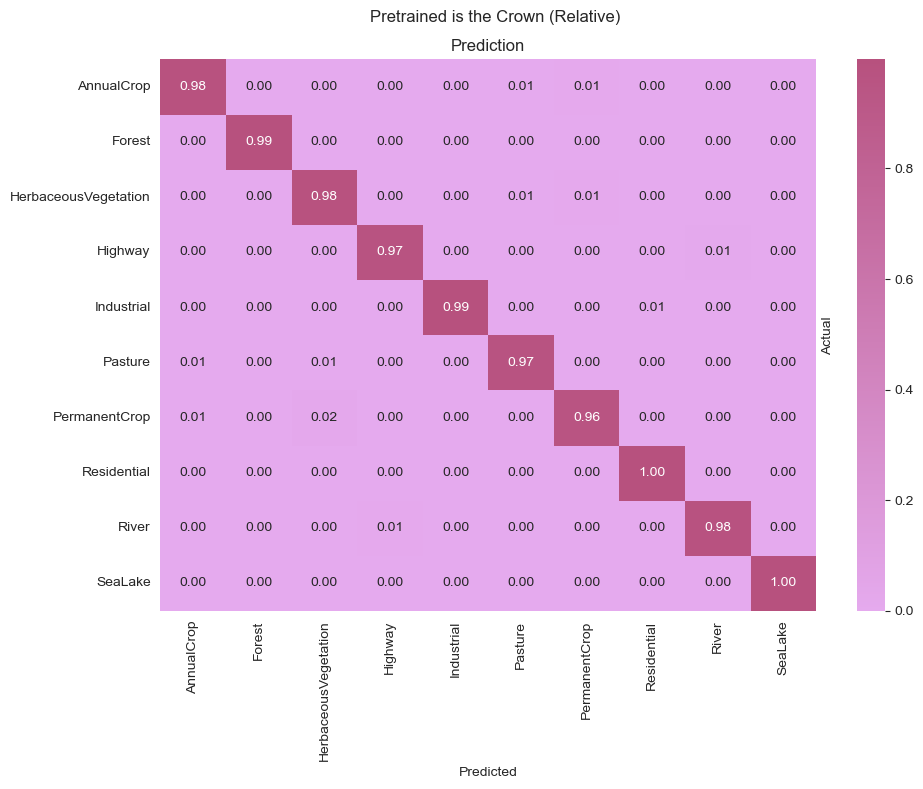


Plotting Matrix now




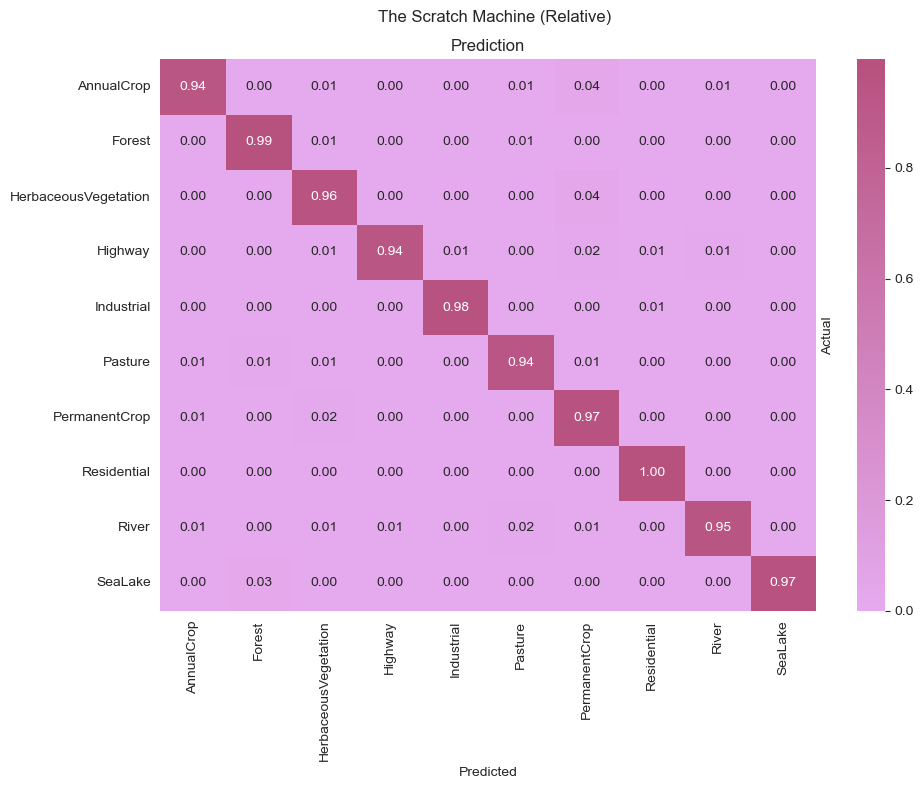

In [23]:
def plot_confusion_matrix(confusion_matrix,labels,titel, relative:bool = False):
    print("\x1b[32m\nPlotting Matrix now\n\x1b[38;5;188m\n")

    colors = ['#e5aaee','#b7517e']
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    plt.figure(figsize=(10, 8))
    if relative:
        ax = sn.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap=cmap, xticklabels=labels, yticklabels=labels)
    else:
        ax = sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap=cmap, xticklabels=labels, yticklabels=labels)
        
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.yaxis.set_label_position("right")
    ax.set_title('Prediction')
    plt.suptitle(titel)
    plt.tight_layout()
    plt.show()


# absolute
plot_confusion_matrix(pretrained_data, label_map.values(), "Pretrained is the Crown (Absolute)", False)
plot_confusion_matrix(scratch_data,label_map.values(), "The Scratch Machine (Absolute)", False)
# relative
plot_confusion_matrix(pretrained_data_relative, label_map.values(), "Pretrained is the Crown (Relative)", True)
plot_confusion_matrix(scratch_data_relative,label_map.values(), "The Scratch Machine (Relative)", True)